#### 캐글 주택가격 분석

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_org = pd.read_csv('house_price.csv')
df = df_org.copy()
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
# Null값 확인
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
df.shape

(1460, 81)

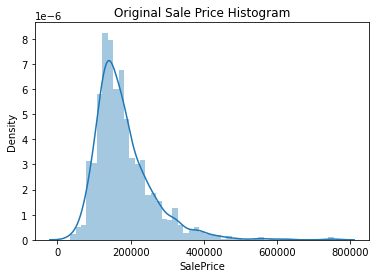

In [5]:
plt.title('Original Sale Price Histogram')
sns.distplot(df.SalePrice)

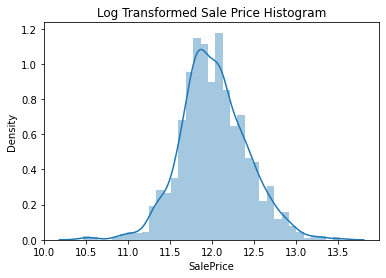

In [6]:
# 결과값 정규 분포로 형태 변환 (로그 변환)
# log1p()로 학습한 뒤 예측 시에는 expm1() 환원
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(df.SalePrice)
sns.distplot(log_SalePrice)

In [7]:
# Null 값이 많은 피처인 PoolQC, MiscFeature, Alley 등 삭제
df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 컬럼은 평균값으로 대체
df.fillna(df.mean(), inplace=True)

In [8]:
# SalePrice 로그 변환
original_SalePrice = df.SalePrice
df.SalePrice = np.log1p(df.SalePrice)

In [9]:
# Null값이 있는 피처명과 타입을 추출
null_column_count = df.isnull().sum()[df.isnull().sum() > 0]
print('🧡 Null 피처의 Type :\n', df.dtypes[null_column_count.index])

🧡 Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [10]:
# 문자형 피처는 원-핫 인코딩으로 변환
print('get_dummies() 수행 전 데이터 shape:', df.shape)
df_oh = pd.get_dummies(df)
print('get_dummies() 수행 후 데이터 shape:', df_oh.shape)

null_column_count = df_oh.isnull().sum()[df_oh.isnull().sum() > 0]
print('💛 Null 피처의 Type :\n', df_oh.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 271)
💛 Null 피처의 Type :
 Series([], dtype: object)


In [11]:
# RMSE 계산 함수 생성

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

#### **선형회귀 모델 학습 예측 평가**

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_oh['SalePrice']
X_features = df_oh.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 선형회귀, Ridge, Lasso 학습, 예측, 평가
lr = LinearRegression()
lr.fit(X_train, y_train)
ridge = Ridge()
ridge.fit(X_train, y_train)
lasso = Lasso()
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154205, 0.12750846334052995, 0.17628250556471403]

- **Lasso 회귀이 다른 회귀 방식보다 떨어지는 결과.**
- **최적 하이퍼 파라미터 튜닝 ( alpha 하이퍼 파라미터 최적화 수행 ) --> Ridge, Lasso**

In [13]:
def get_top_bottom_coef(model, n=10):
    # coed_ 속성을 기반으로 Series 객체를 샐성. index는 컬럼명
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

- **회귀 계수 시각화**

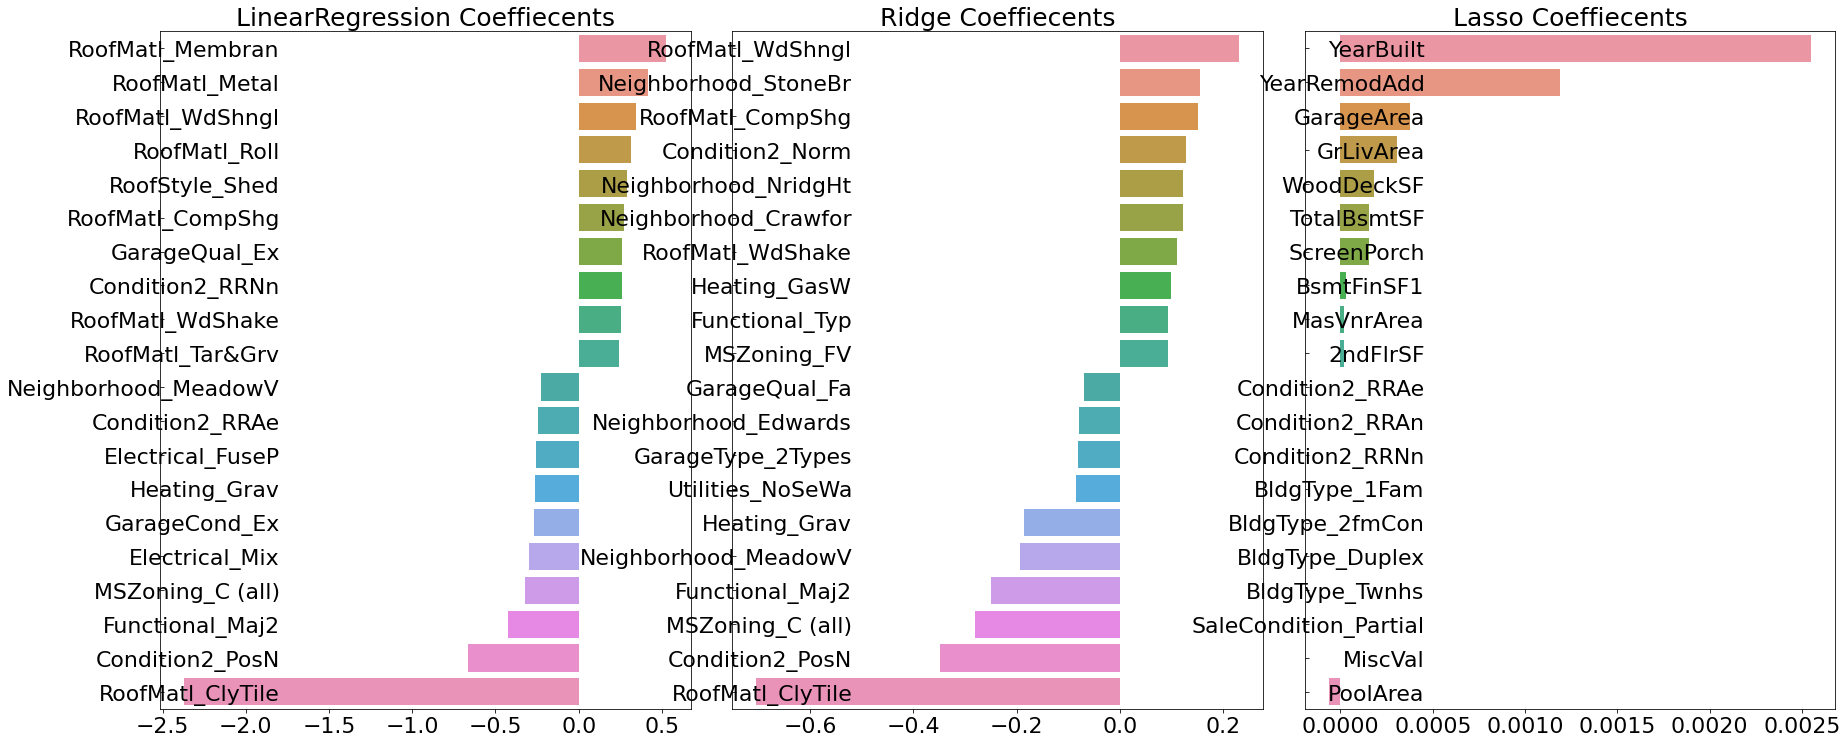

In [17]:
from pandas.core.dtypes.concat import concat_compat
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list  객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현.  한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr, ridge, lasso 모델의 회귀 계수 시각화
models = [lr, ridge, lasso]
visualize_coefficient(models)

- **Lasso의 회귀계수 값이 작고, yearbuilt가 가장 크고 다른 치처의 회귀계수는 너무 작음.**
- **train test split을 사용하지 않고 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정해보자 (cross_val_score 활용)**

In [19]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr, ridge, lasso 모델의 CV RMSE 값 출력
models = [lr, ridge, lasso]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


- 5r개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우 성능이 떨어짐.
- 릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터를 변화시키면서 최적값을 도출해보자
- 이를 반복 작업할 별도의 함수 생성

In [25]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE rkqt:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))


ridge_params= {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params= {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE rkqt:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE rkqt:0.142, 최적 alpha:{'alpha': 0.001}


dddd

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


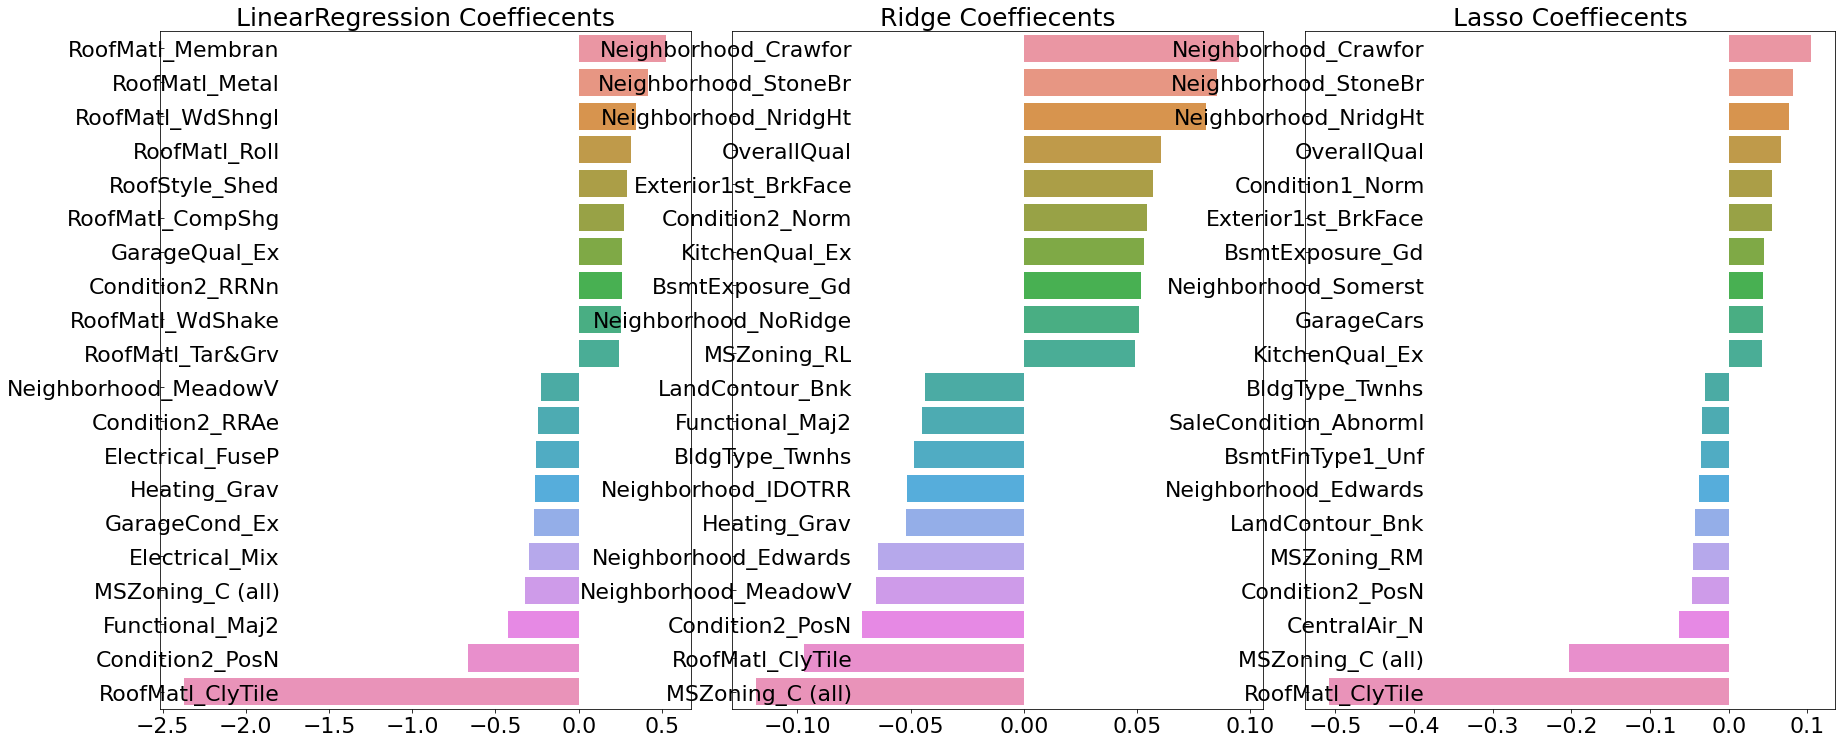

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)
ridge = Ridge(alpha=12)
ridge.fit(X_train, y_train)
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

# 모든 모델의 RMSW 출력
models = [lr, ridge, lasso]
get_rmses(models)

# 모든 모델의 회귀계수 시각화
models = [lr, ridge, lasso]
visualize_coefficient(models)